In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 8
val_batch_size = 8

image_size = 256

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_resnet50.add(Bidirectional(LSTM(16, activation='relu', return_sequences= False)))
model_resnet50.add(Dense(5, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 16384)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 256)            16909312  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                34944     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 40,532,133
Trainable params: 16,944,421
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
760/760 [==============================] - 88s 104ms/step - loss: 0.6746 - acc: 0.7625 - val_loss: 0.2686 - val_acc: 0.9124
Epoch 2/30
760/760 [==============================] - 77s 101ms/step - loss: 0.2676 - acc: 0.9051 - val_loss: 0.2484 - val_acc: 0.9226
Epoch 3/30
760/760 [==============================] - 77s 101ms/step - loss: 0.1385 - acc: 0.9508 - val_loss: 0.1856 - val_acc: 0.9409
Epoch 4/30
760/760 [==============================] - 77s 101ms/step - loss: 0.1345 - acc: 0.9567 - val_loss: 0.2572 - val_acc: 0.9409
Epoch 5/30
760/760 [==============================] - 77s 101ms/step - loss: 0.0760 - acc: 0.9729 - val_loss: 0.1518 - val_acc: 0.9603
Epoch 6/30
760/760 [==============================] - 77s 101ms/step - loss: 0.0400 - acc: 0.9877 - val_loss: 0.2537 - val_acc: 0.9358
Epoch 7/30
760/760 [==============================] - 77s 102ms/step - loss: 0.1883 - acc: 0.9480 - val_loss: 0.2997 - val_acc: 0.9002

Epoch 00007: ReduceLROnPlateau reducing learning rate 

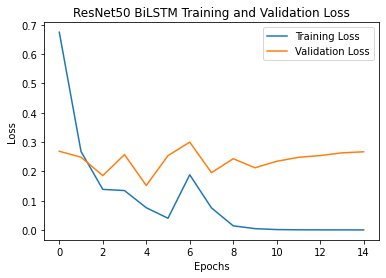

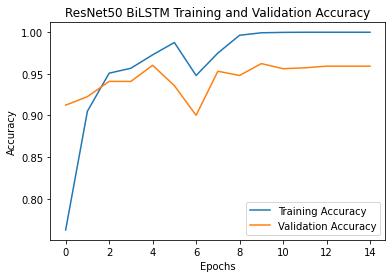

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 7s 56ms/step - loss: 0.1518 - acc: 0.9603


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 8s 54ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.94313   0.96602   0.95444       206
            covid19    0.96667   0.96209   0.96437       211
             normal    0.96154   0.95694   0.95923       209
       tuberculosis    0.99270   0.97143   0.98195       140
    viral_pneumonia    0.94907   0.94907   0.94907       216

           accuracy                        0.96029       982
          macro avg    0.96262   0.96111   0.96181       982
       weighted avg    0.96048   0.96029   0.96033       982



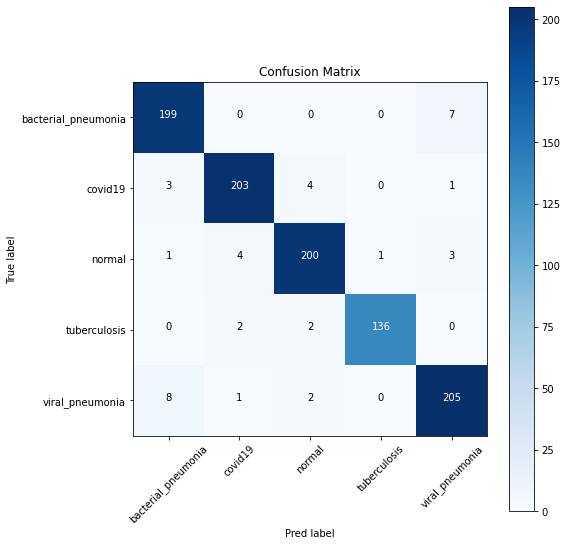

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
760/760 [==============================] - 38s 50ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.98301   0.99590   0.98941      1220
            covid19    0.99754   0.97908   0.98823      1243
             normal    0.97466   0.99676   0.98559      1235
       tuberculosis    0.99914   0.99829   0.99872      1170
    viral_pneumonia    0.99581   0.97937   0.98752      1212

           accuracy                        0.98980      6080
          macro avg    0.99003   0.98988   0.98989      6080
       weighted avg    0.98994   0.98980   0.98981      6080



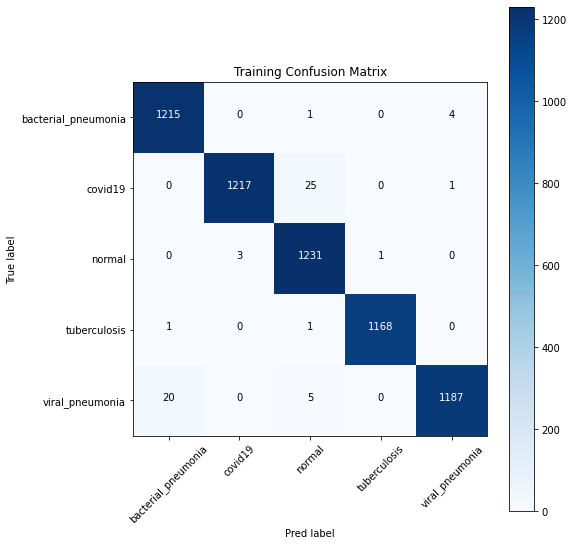

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_vgg19.add(Bidirectional(LSTM(16, activation='relu', return_sequences= False)))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 4096)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8, 256)            4326400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                34944     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 24,385,893
Trainable params: 4,361,509
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
760/760 [==============================] - 83s 101ms/step - loss: 2.0263 - acc: 0.3456 - val_loss: 1.4440 - val_acc: 0.4196
Epoch 2/30
760/760 [==============================] - 75s 98ms/step - loss: 1.1021 - acc: 0.5395 - val_loss: 1.2770 - val_acc: 0.5102
Epoch 3/30
760/760 [==============================] - 75s 98ms/step - loss: 0.7965 - acc: 0.6766 - val_loss: 1.1886 - val_acc: 0.5580
Epoch 4/30
760/760 [==============================] - 75s 98ms/step - loss: 0.5698 - acc: 0.7748 - val_loss: 1.1275 - val_acc: 0.6008
Epoch 5/30
760/760 [==============================] - 75s 99ms/step - loss: 0.4046 - acc: 0.8485 - val_loss: 1.1126 - val_acc: 0.6324
Epoch 6/30
760/760 [==============================] - 76s 100ms/step - loss: 0.2769 - acc: 0.9030 - val_loss: 1.1344 - val_acc: 0.6456
Epoch 7/30
760/760 [==============================] - 75s 98ms/step - loss: 0.1884 - acc: 0.9401 - val_loss: 1.1188 - val_acc: 0.6548
Epoch 8/30
760/760 [==============================] - 75s 99

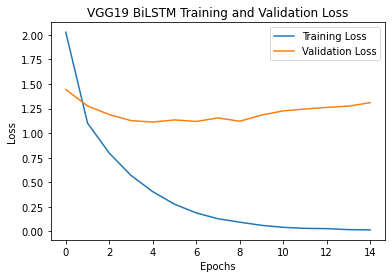

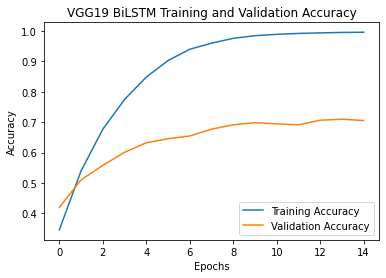

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 9s 76ms/step - loss: 1.1126 - acc: 0.6324


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 9s 72ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.55691   0.66505   0.60619       206
            covid19    0.70186   0.53555   0.60753       211
             normal    0.64602   0.69856   0.67126       209
       tuberculosis    0.71338   0.80000   0.75421       140
    viral_pneumonia    0.58854   0.52315   0.55392       216

           accuracy                        0.63238       982
          macro avg    0.64134   0.64446   0.63862       982
       weighted avg    0.63629   0.63238   0.62993       982



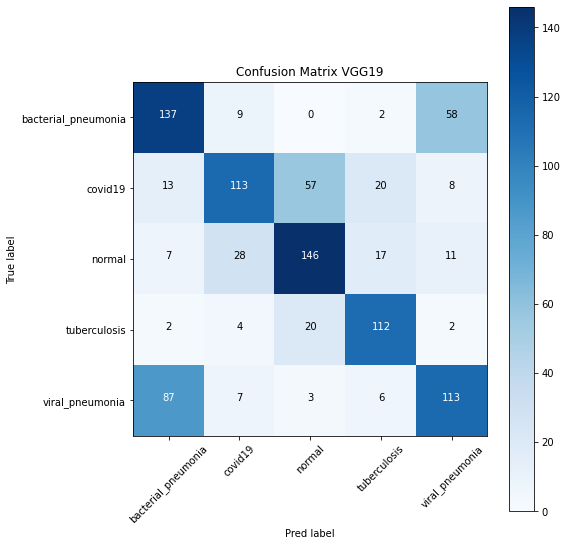

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
760/760 [==============================] - 55s 73ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.87060   0.93197   0.90024      1220
            covid19    0.93286   0.84956   0.88926      1243
             normal    0.89764   0.92308   0.91018      1235
       tuberculosis    0.92180   0.94701   0.93423      1170
    viral_pneumonia    0.89915   0.86799   0.88329      1212

           accuracy                        0.90345      6080
          macro avg    0.90441   0.90392   0.90344      6080
       weighted avg    0.90436   0.90345   0.90318      6080



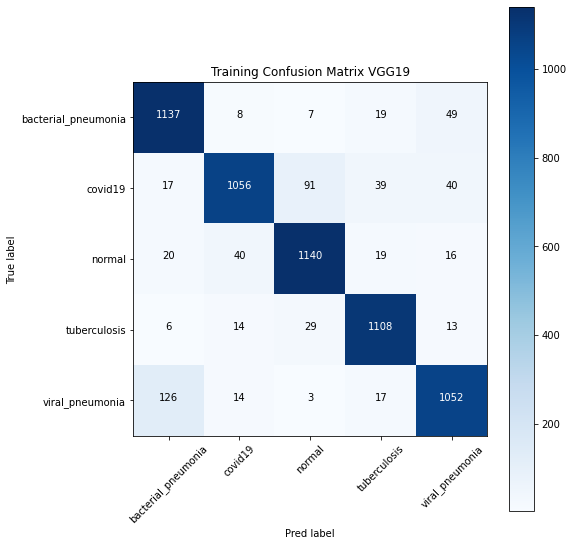

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_inceptionv3.add(Bidirectional(LSTM(16, activation='relu', return_sequences= False)))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 12288)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 6, 256)            12715008  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                34944     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 34,552,901
Trainable params: 12,750,117
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
760/760 [==============================] - 70s 82ms/step - loss: 0.7686 - acc: 0.6786 - val_loss: 0.6091 - val_acc: 0.7546
Epoch 2/30
760/760 [==============================] - 60s 78ms/step - loss: 0.4734 - acc: 0.8069 - val_loss: 0.5471 - val_acc: 0.7719
Epoch 3/30
760/760 [==============================] - 60s 79ms/step - loss: 0.3488 - acc: 0.8590 - val_loss: 0.5481 - val_acc: 0.7841
Epoch 4/30
760/760 [==============================] - 61s 80ms/step - loss: 0.2562 - acc: 0.9053 - val_loss: 0.5577 - val_acc: 0.8024
Epoch 5/30
760/760 [==============================] - 60s 79ms/step - loss: 0.1801 - acc: 0.9367 - val_loss: 0.6000 - val_acc: 0.8126
Epoch 6/30
760/760 [==============================] - 60s 79ms/step - loss: 0.1222 - acc: 0.9609 - val_loss: 0.6420 - val_acc: 0.8157
Epoch 7/30
760/760 [==============================] - 60s 79ms/step - loss: 0.0774 - acc: 0.9778 - val_loss: 0.6915 - val_acc: 0.8075
Epoch 8/30
760/760 [==============================] - 60s 79ms

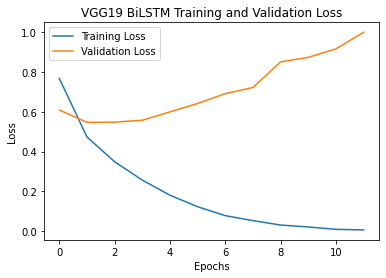

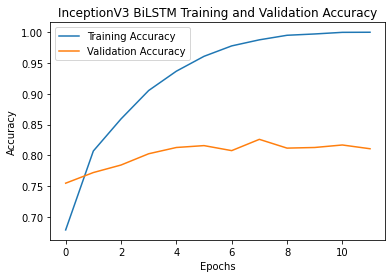

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 50ms/step - loss: 0.5471 - acc: 0.7719


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 8s 48ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.66239   0.75243   0.70455       206
            covid19    0.82192   0.85308   0.83721       211
             normal    0.82353   0.80383   0.81356       209
       tuberculosis    0.91057   0.80000   0.85171       140
    viral_pneumonia    0.70792   0.66204   0.68421       216

           accuracy                        0.77189       982
          macro avg    0.78527   0.77427   0.77825       982
       weighted avg    0.77636   0.77189   0.77276       982



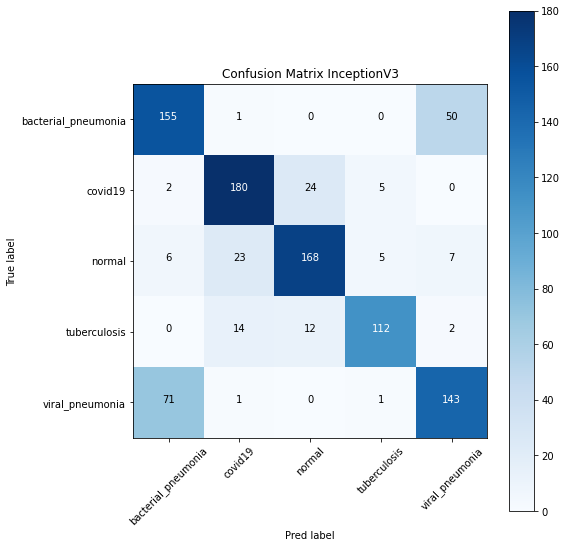

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [34]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
760/760 [==============================] - 32s 42ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.80600   0.85820   0.83128      1220
            covid19    0.90872   0.89702   0.90283      1243
             normal    0.86232   0.86721   0.86476      1235
       tuberculosis    0.93812   0.89402   0.91554      1170
    viral_pneumonia    0.82038   0.81023   0.81528      1212

           accuracy                        0.86530      6080
          macro avg    0.86711   0.86533   0.86594      6080
       weighted avg    0.86673   0.86530   0.86573      6080



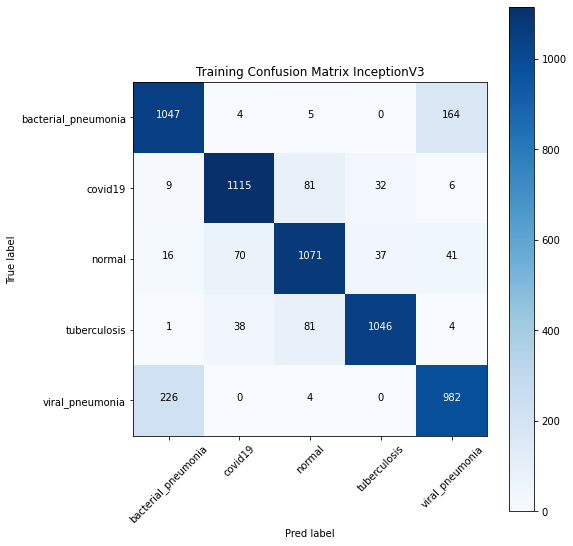

In [35]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()